# Machine learning algorithms for recognizing handwritten double-digit images

##Import the modules

In [5]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import pandas as pd
 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam

## Set the Variables

In [6]:
### Load raw MNIST data as tuples of numpy arrays
### Each tuple is: (examples of images, corresponding labels)
traintuple, testuple = tf.keras.datasets.mnist.load_data()

### Set values for data construction
image_size = (28,56) # base shape of a target image
model_kinds = ["miniNN", "CNN", "DNN", "comboNN", "ocNN"]
noise_levels = ["no", "high", "low", "var"]
training_keys = []
for nc in noise_levels:
    for k in model_kinds:
        training_keys.append((k, nc))

### Dict to translate noise level to description
noise2condition = {nc:d for (nc, d) in zip(noise_levels,
                                        ["No noise", "Low noise", "High noise", "Variable noise"])} 

### Number of images to generate for each category
N_train = 100000    # for training
N_test = 10000      # for evaluation
N_val = 5000        # for use while training

### Training hyperparameters (same for all models)
batch_size = 1000
validation_batch_size = 500
epochs = 10
learning_rate = 0.001
input_layer = layers.Input(shape=(28, 56, 1))

11493376/11490434 [==============================] - 0s 0us/step


# Construct the Data

### Construction

In [7]:
############ Define Functions for data construction

def scale_array(arr):
    '''Scale an array of numbers.
        Params: numpy array of values to be scaled
        Returns: the same array with values scaled to (0,1)
    '''
    max = np.max(arr)
    min = np.min(arr)
    scaled = (arr - min)/(max - min)
    return scaled
print("Loaded function scale_array(arr)")

def get_noise(image, noise_condition="no"):
    ''' Add a normal disitribution of noise to an image
        Params: image: numpy array with values (0,1)
                noise_factor: one of "no", "low", "high", "var"
        Returns: noisy image array re-normalized to (0,1)
    '''
    cond2num = {"no":0, 
                "low":0.3, 
                "high":1.3, 
                "var":1.3*rd.random()} # Different value each call, (0,1.3*std)
    noise_factor = np.std(image)*cond2num[noise_condition]
    noise = np.random.normal(np.mean(image), 
                             noise_factor, 
                             size=image.shape)
    # RE-normalize combined image back to (0,1)
    return scale_array(noise + image)
print("Loaded function get_noise(image, noise_condition)")

def doubleDigits(datatuple, nc="no"):
    ''' Merge two single-digit images into one double-digit image.
        Params: images: np.array with shape (N,28,28), values 0 to 255
                answers: np.array with shape (N,), values 0 to 9
                nf: "noise factor" (float) is multiples/fractions of image std
        Returns: noisy double-digit image as a numpy array with shape (28,56),
                with values normed to (0.0, 1.0); 
                and the corresponding label, with values now 0 to 99
    '''
    (images,answers)=datatuple  # = (x, y)
    
    # Randomly select left and right single digit images
    # with values 0 to 9, from the same raw training or test data set
    left_index = rd.randrange(0, len(answers))   
    right_index = rd.randrange(0, len(answers))
    # Calculate double digit label 0 to 99
    answer = answers[left_index]*10 + answers[right_index]
    
    # Have to scale them here because they have
    # different distributions of pixel values
    left_scaled = scale_array(images[left_index])
    right_scaled = scale_array(images[right_index])

    # Make background array with shape (28,56)
    image = np.zeros(image_size)
    # Group digits closer to middle of new image
    width = image_size[1]
    half_width = width//2  
    # Shift left digit to the right
    image[:,8:half_width+4] = left_scaled[:,4:half_width]
    # Shift right digit to the left
    image[:,half_width-4:width-8] += right_scaled[:,0:half_width-4]
    # Have to clip in case some bright pixels overlap
    image = image.clip(0,1)
    # Add noise to the new double digit image
    # get_noise() will overlay a Normal distribution of
    # random pixel values centered on the mean of pixel values
    # in the image, and with "noise_factor" as the width of the
    # distribution in multiples or fractions of the 
    # standard deviation of the pixel values in the image:
    # 0 = no distortion, +inf = uniform distribution  
    # Rescale pixel values to (0,1) (again!)
    image = get_noise(image, nc)  
    return image, int(answer)              
print("Loaded function doubleDigits(datatuple, nc=no)")

def getDoubleDigits(datatuple, how_many=1, nc="no"):
    ''' Aggregate a specified number of two-digit images, with or without noise
        Params: image array of size (N, (image size)),
                answers array of size (N,)
        Returns: a single 28x56 double-digit image and
                 the corresponding array of int labels
    '''
    yy = np.zeros((how_many,),dtype=int)
    xx = np.zeros((how_many, image_size[0], image_size[1]))
    for i in range(how_many):
        dd, ans = doubleDigits(datatuple, nc)
        yy[i] = ans
        xx[i] = dd
    return (xx, yy) # (new image, corresponding label)
print("Loaded function getDoubleDigits(datatuple,how_many=1,nc=no)")

Loaded function scale_array(arr)
Loaded function get_noise(image, noise_condition)
Loaded function doubleDigits(datatuple, nc=no)
Loaded function getDoubleDigits(datatuple,how_many=1,nc=no)


In [8]:
### Generate double-digit training, testing, and validation images
### One set for each noise level: no, low, high, and var

train_data = {} # {noise level : tuple of training data (x,y)}
val_data = {}   # {noise level : val data (x,y)}
test_data = {}  # {noise level : test data (x,y)}

for nc in noise_levels:
    print ("Noise level:", noise2condition[nc])
    if nc is "no":
        ### Make a set of training, validation, and test images
        ### First set with no noise added as a baseline
        # Training set constructed from training set in MNIST
        x_train, y_train = getDoubleDigits(traintuple, N_train, nc=nc)
        print("Made",N_train,"new double-digit images to train on.")
        # Test and validation sets constructed from test images in MNIST
        x_val, y_val = getDoubleDigits(testuple, N_val, nc=nc)
        print("Made",N_val,"new double-digit images to validate on.")
        x_test, y_test = getDoubleDigits(testuple, N_test, nc=nc)
        print("Made",N_test,"new double-digit images to test on.")
    else:
        # Add noise to the baseline "no noise" set 
        x0_train, y_train = train_data["no"]
        x0_val, y_val = val_data["no"]
        x0_test, y_test = test_data["no"]
        x_train = np.array([get_noise(img.reshape(image_size),nc) for img in x0_train])
        print("Added",noise2condition[nc],"to",N_train,"double-digit images for training.")
        x_val = np.array([get_noise(img.reshape(image_size),nc) for img in x0_val])
        print("Added",noise2condition[nc],"to",N_val,"double-digit images for validation.")
        x_test = np.array([get_noise(img.reshape(image_size),nc) for img in x0_test])
        print("Added",noise2condition[nc],"to",N_test,"double-digit images for evaluation.")        
    
    ### Add a black-and-white channel dimension
    x_train = x_train[..., np.newaxis].astype("float32")
    x_val = x_val[..., np.newaxis].astype("float32")
    x_test = x_test[..., np.newaxis].astype("float32")

    ### Update dict for converting from noiselevel to dataset
    train_data.update({nc:(x_train, y_train)})
    val_data.update({nc:(x_val, y_val)}) 
    test_data.update({nc:(x_test, y_test)})


Noise level: No noise
Made 100000 new double-digit images to train on.
Made 5000 new double-digit images to validate on.
Made 10000 new double-digit images to test on.
Noise level: Low noise
Added Low noise to 100000 double-digit images for training.
Added Low noise to 5000 double-digit images for validation.
Added Low noise to 10000 double-digit images for evaluation.
Noise level: High noise
Added High noise to 100000 double-digit images for training.
Added High noise to 5000 double-digit images for validation.
Added High noise to 10000 double-digit images for evaluation.
Noise level: Variable noise
Added Variable noise to 100000 double-digit images for training.
Added Variable noise to 5000 double-digit images for validation.
Added Variable noise to 10000 double-digit images for evaluation.


### Data distribution

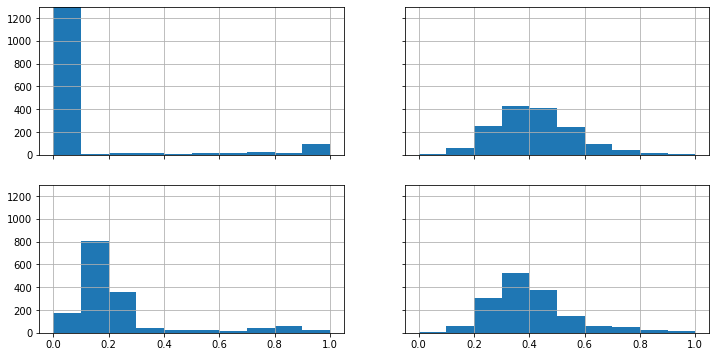

In [9]:
idx = rd.randrange(val_data["high"][0].shape[0])
xtd0 = pd.DataFrame(val_data["no"][0].reshape(-1,28*56)).iloc[idx]
xtdh = pd.DataFrame(val_data["high"][0].reshape(-1,28*56)).iloc[idx]
xtdl = pd.DataFrame(val_data["low"][0].reshape(-1,28*56)).iloc[idx]
xtdv = pd.DataFrame(val_data["var"][0].reshape(-1,28*56)).iloc[idx]

f = plt.figure(figsize=(12,6))
histax = f.subplots(2,2, sharex=True, sharey=True)
histax = histax.reshape((4,))
for i, xt in enumerate([xtd0, xtdh, xtdl, xtdv]):
    ax = histax[i]
    ax.set_ylim(0,1300)
    xt.hist(ax=ax)

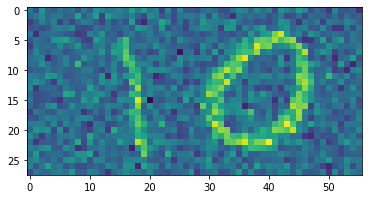

In [10]:
plt.imshow(np.array(xtdv).reshape(image_size))

In [11]:
arr0_test = np.zeros((x0_test.shape[0],2))
for i, img in enumerate(x0_test):
    #img.reshape(image_size)
    arr0_test[i,0] = img.mean()
    arr0_test[i,1] = img.std()

arr1_test = np.zeros((test_data["low"][0].shape[0],2))
for i, img in enumerate(test_data["low"][0]):
    #img.reshape(image_size)
    arr1_test[i,0] = img.mean()
    arr1_test[i,1] = img.std()

arr2_test = np.zeros((test_data["high"][0].shape[0],2))
for i, img in enumerate(test_data["high"][0]):
    #img.reshape(image_size)
    arr2_test[i,0] = img.mean()
    arr2_test[i,1] = img.std()

arr3_test = np.zeros((test_data["var"][0].shape[0],2))
for i, img in enumerate(test_data["var"][0]):
    #img.reshape(image_size)
    arr3_test[i,0] = img.mean()
    arr3_test[i,1] = img.std()

print(arr0_test.mean(), arr0_test.std())
print(arr1_test.mean(), arr1_test.std())
print(arr2_test.mean(), arr2_test.std())
print(arr3_test.mean(), arr3_test.std())

0.21927581370864063 0.09308509577836263
0.24568797419667243 0.04518566964133196
0.2902793789472431 0.1424878995441593
0.26241437432020903 0.1016065525773951


### Sample set

Answers: [59 31 49 93 56]


<Figure size 432x288 with 0 Axes>

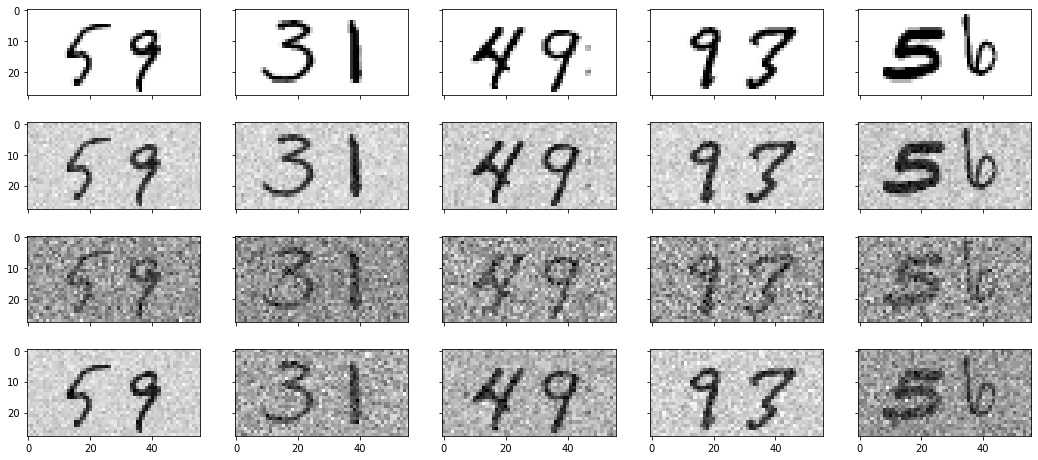

In [12]:
### Show a sample of five images for each noise level
x0, y0 = getDoubleDigits(traintuple, nc="no", how_many=5)
print('Answers:',y0) 

x1 = np.array([get_noise(img.reshape(image_size),"low") for img in x0])
x2 = np.array([get_noise(img.reshape(image_size),"high") for img in x0])
x3 = np.array([get_noise(img.reshape(image_size),"var") for img in x0])

plt.set_cmap('binary')
f,a = plt.subplots(4,5,True,True,)
f.set_size_inches(18,8)
a=a.reshape(20,)
for i, k in enumerate([x0,x1,x2,x3]):
    for j in range(5): 
        a[5*i+j].imshow(k[j])

# Build and Train the Models

In [13]:
### Define functions for building, training, compiling and evaluating models

def build_model(key, verbose=True):
    '''Builds a model of each kind, for each noise level
        params: a tuple of "model kind" and "noise level"
                verbose turns on printed reports
        returns: a model of the specified kind, to be
                 dedicated to noise of the specified level
    '''
    (model_kind, noise) = key
    ## Input layer, same for for all models
    input_layer = layers.Input(shape=(image_size[0], image_size[1], 1))
        
    if "miniNN" in model_kind:
        ########### Build model miniNN as a minimal, baseline model 
        x = layers.Flatten()(input_layer)#
        output_layer = layers.Dense(100, activation='softmax')(x)
        miniNN = Model(input_layer, output_layer, name="miniNN_"+noise)
        if verbose: print ("built", miniNN.name)
        return miniNN

    elif "CNN" in model_kind:
        ########### Build model CNN: typical convolutional neural network
        x = layers.Conv2D(20, 3, activation='relu')(input_layer)#, padding='same'
        x = layers.MaxPooling2D(2)(x)
        x = layers.Conv2D(30, 2, activation='relu')(x) 
        x = layers.AveragePooling2D(2)(x)
        x = layers.Flatten()(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        CNN = Model(input_layer, output_layer, name="CNN_"+noise)
        if verbose: print ("built", CNN.name)
        return CNN
    
    elif "DNN" in model_kind:
        ########### Build model DNN, a densely connected NN with 4 layers
        x = layers.Flatten()(input_layer)
        x = layers.Dropout(0.05)(x)
        x = layers.Dense(999, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(333, activation='relu')(x)
        #x = layers.Dropout(0.1)(x) 
        output_layer = layers.Dense(100, activation='softmax')(x)
        DNN = Model(input_layer, output_layer, name="DNN_"+noise)
        if verbose: print ("built", DNN.name)
        return DNN

    elif "comboNN" in model_kind:
        ########### Build model comboNN, a hybrid of both convolutional and dense layers 
        x = layers.Conv2D(20, 3, activation='relu')(input_layer)
        x = layers.AveragePooling2D(2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(720, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        comboNN = Model(input_layer, output_layer, name="comboNN_"+noise)
        if verbose: print ("built", comboNN.name)
        return comboNN

    elif "ocNN" in model_kind:
        ########### Build "overcomplicated" model ocNN, of superfluous complexity 
        x = layers.Flatten()(input_layer)
        x = layers.Dense(800, activation='relu')(x)

        x1 = layers.Dropout(0.2)(x)
        x1 = layers.Dense(500, activation='relu')(x1) 
        x1 = layers.Dropout(0.05)(x1)

        x2 = layers.Dropout(0.1)(x)
        x2 = layers.Dense(300, activation='relu')(x2) 

        y1 = layers.Conv2D(25, 5, activation='relu')(input_layer)
        y1 = layers.MaxPooling2D(2)(y1)
        y1 = layers.Conv2D(25, 3, activation='relu')(y1) 
        y1 = layers.AveragePooling2D(2)(y1)
        y1 = layers.Conv2D(25, 2, activation='relu', padding='same')(y1)
        y1 = layers.Flatten()(y1)
        y1 = layers.Dropout(0.05)(y1)
        
        y2 = layers.Conv2D(22, 3, activation='relu')(input_layer) 
        y2 = layers.Conv2D(33, 2, activation='relu', padding='same')(y2)
        y2 = layers.MaxPooling2D(2)(y2)
        y2 = layers.Conv2D(11, 2, activation='relu')(y2)
        y2 = layers.Flatten()(y2)
        
        z1 = layers.Concatenate()([x1,y1])
        z1 = layers.Dropout(0.1)(z1)

        z2 = layers.Concatenate()([x2,y2])
        z2 = layers.Dropout(0.1)(z2)

        z = layers.Dropout(0.4)(x)
        z = layers.Concatenate()([z,z1])
        z = layers.Concatenate()([z,z2])
        z = layers.Dense(2222,activation="relu")(z)
        z = layers.Dropout(0.2)(z)
        z = layers.Dense(222,activation="relu")(z)
        z = layers.Dropout(0.1)(z)

        logits_layer = layers.Dense(100, activation='softmax')(z) 
        ocNN = Model(input_layer, logits_layer, name="ocNN_"+noise)
        if verbose: print ("built", ocNN.name)
        return ocNN

    else:
        print ("Could not find that kind of model.")
        return None
print("loaded function build_model((model_kind, noise_level))")

## Same training loop for all models
def train(model, traintuple, valtuple, epochs=epochs):
    '''Train a model on the given sets of data
        Params: the given model,
                the train data as a tuple of x,y,
                the test data as a tuple of x,y
        Returns: a dictionary of metric values after each epoch of training
    '''
    (x_train, y_train) = traintuple
    (x_val, y_val) = valtuple

    history = model.fit(x=x_train,
                        y=y_train,
                        batch_size=batch_size,
                        validation_data=valtuple,
                        validation_batch_size=validation_batch_size,
                        epochs=epochs,  
                        verbose=1)   
    return history.history
print("loaded function train(model, traintuple, testuple, epochs=epochs)")

## All models are compiled the same
def compile_model(model):    
    model.compile(  loss="sparse_categorical_crossentropy",
                    optimizer=RMSprop(lr=learning_rate),                    
                    metrics=['acc'])
    print ("Compiled model", model.name)
print("loaded function compile_model(model)")

## Plot the learning curves for each model:
## accuracy and validation_accuracy after each training epoch
def plotLearningCurves(history):
    acc = history['acc']
    val_acc = history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Accuracy after each training epoch')
print("Loaded function plotLearningCurves(history)")

loaded function build_model((model_kind, noise_level))
loaded function train(model, traintuple, testuple, epochs=epochs)
loaded function compile_model(model)
Loaded function plotLearningCurves(history)


In [42]:
epochs = 10
learning_rate = 0.002

In [ ]:
### Build all 20 models
get_model = {}  # Training key --> model
for key in training_keys:  # One training key for each model on each noise level.
     model = build_model(key, verbose=False)  
     get_model.update({key:model}) # One model for each training key

### Compile and Train all 20 models
stats = {}
for key in training_keys:    
    nc = key[1]
    model = get_model[key]
    compile_model(model)
    train_stats = train(model, train_data[nc], val_data[nc], epochs=epochs)
    stats.update({key:train_stats})

In [ ]:
######### Print out summary tables for all the models
for m in model_kinds:
    print(get_model[(m,"no")].summary(),"\n")

In [ ]:
#get_model.update( {("miniNN","no"):build_model(("miniNN","no"),True)} )
tf.keras.utils.plot_model(get_model[("ocNN","no")], show_layer_names=True, show_shapes=True, to_file="diagram_ocNN.png")

#Evaluate the Results

### Training stats

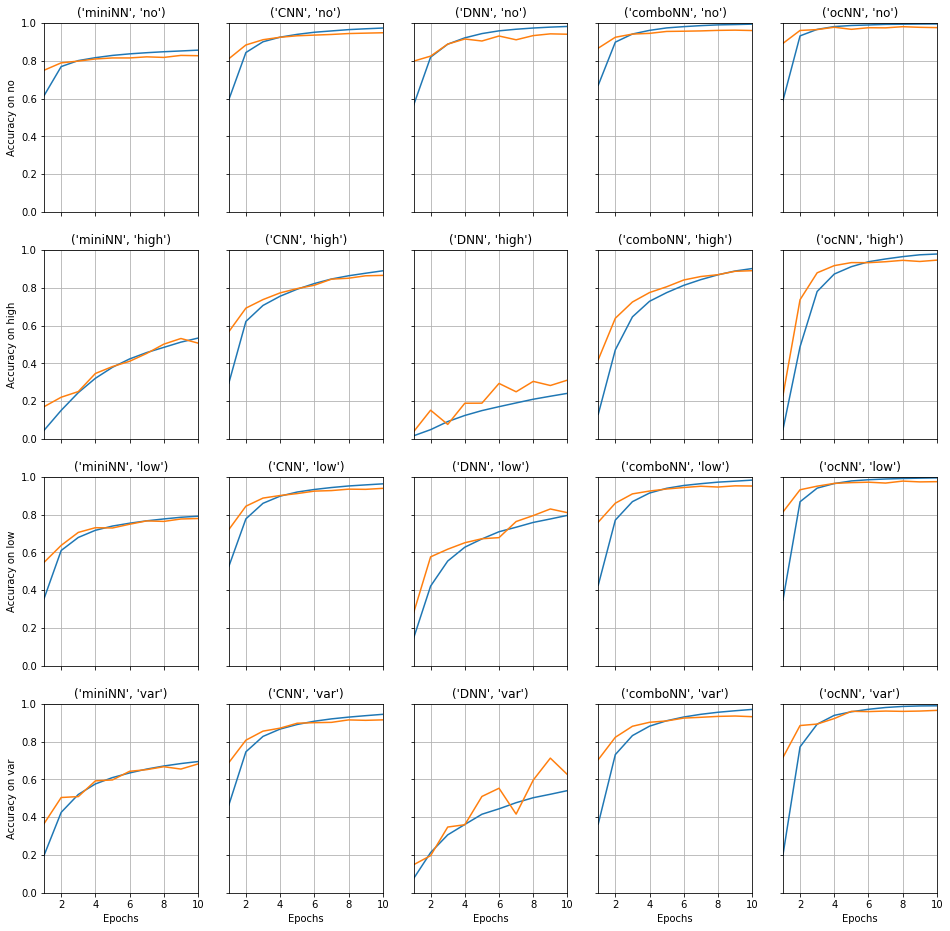

In [73]:
### Plot the learning curves for all 20 models during training
ncols = 5 #number of model types
nrows = 4 #number of noise conditions

fig = plt.figure(figsize=(16,16))

axarr = fig.subplots(nrows,ncols,sharey=True,sharex=True)
axarr = axarr.reshape((nrows*ncols,))

for i, tk in enumerate(training_keys):
    ax = axarr[i]
    #ax.margins(0.5)
    if i%ncols==0: ax.set_ylabel("Accuracy on "+tk[1])
    if i>=15: ax.set_xlabel("Epochs")   
    ax.set_title(tk)
    ax.set_xlim(1,epochs)
    ax.set_ylim(0,1)
    ax.grid(True)
    acc_line, = ax.plot(range(1,epochs+1),stats[tk]['acc'])
    val_line, = ax.plot(range(1,epochs+1),stats[tk]['val_acc'])

#fig.suptitle("Learning Curves: Accuracy by Epoch for each (model, noise level)",va='center')

###Evaluation

In [ ]:
### Collect Evaluation results for all models and all noise levels

results = {}
evalkeys = []
for key in training_keys:
    model = get_model[key]
    print (">>>>>>>>>>>>>>> Key:", key)
    for nl in noise_levels:
        evalkey = (model.name, nl)
        evalkeys += [evalkey]
        x, y = test_data[nl]
        evaluated = model.evaluate(x=x, 
                                   y=y, 
                                   verbose=0, 
                                   batch_size=validation_batch_size)
        results.update({evalkey:round(evaluated[1], 4)})
        condition = noise2condition[nl]
        print(model.name,"tested on",condition,":",round(evaluated[1], 4))

In [75]:
### Build a DataFrame to hold the results of evaluation 
rows = len(training_keys)
results_df = pd.DataFrame(columns=["model"]+["trained_on"]+noise_levels, index=range(rows))
for row, (model_kind, train_condition) in enumerate(training_keys):
    results_df.iloc[row]["model"]=model_kind
    results_df.iloc[row]["trained_on"]=train_condition
    for test_condition in noise_levels:
        results_df.iloc[row][test_condition] = results[(model_kind+"_"+train_condition, test_condition)]
#results_df = results_df.sort_values(["model","trained_on"])

In [ ]:
print(results_df.sort_values(["model","trained_on"]))

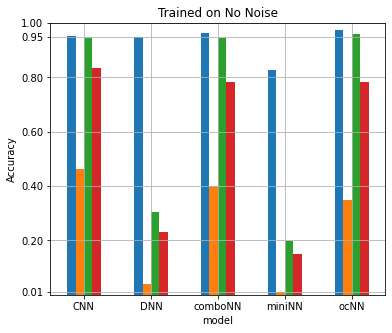

In [92]:
## Graph of baseline results
## Plot results for each training condition (noise level) ####
f = plt.figure(figsize=(6,5))
for i,nl in enumerate(["no"]):
    #leg = i==0
    condax = f.add_subplot(1,1,i+1)
    condax.set_ylim(ymin=0,ymax=1.0),
    r_df = results_df.loc[lambda df: df["trained_on"]==nl].sort_values('model')
    r_df.plot(x="model", 
              y=["no","high","low","var"], 
              kind='bar', 
              ax=condax,            
              title="Trained on No Noise", 
              ylabel="Accuracy",# on No Noise",
              #xlabel="Models Trained on No Noise",
              legend=False,
              grid=True,
              yticks=[0.01]+[t/10 for t in range(2,11,2)]+[0.95],
              )
    plt.xticks(rotation=0)


In [ ]:
## Plot results for each training condition (noise level) ####
f = plt.figure(figsize=(13,12))
for i,nl in enumerate(noise_levels): 
    condax = f.add_subplot(2,2,i+1)
    r_df = results_df.loc[lambda df: df["trained_on"]==nl].sort_values('model')
    r_df.plot("model", 
              ["no","high","low","var"], 
              kind='bar', 
              ax=condax, 
              title="Trained on "+nl+" noise", 
              ylabel="Evaluation Accuracy",
              xlabel="",
              legend=False, #i==0,
              grid=True,
              yticks=[0.01]+[t/10 for t in range(1,10,2)],
              sharey=True,
              )
    plt.xticks(rotation=0)

In [ ]:
## Plot results for each model ####
f = plt.figure(figsize=(13,12))
mks = model_kinds.copy()
mks.remove("miniNN")
for i, m in enumerate(mks):
    r_df = results_df.loc[lambda df: df["model"]==m].sort_values('model')
    r_df.plot(x="trained_on", 
              y=["no","high","low","var"], 
              kind='bar', 
              ax=f.add_subplot(2,2,i+1),
              #ax.set_ylim(0,1),
              title="Model "+m,
              xlabel="Training Noise", 
              ylabel="Evaluation Accuracy",
              yticks=[0.01]+[t/10 for t in range(1,10,2)],
              sharey=True,
              legend=False, #i==0,
              grid=True,
              )
    plt.xticks(rotation=0)

<Figure size 432x432 with 0 Axes>

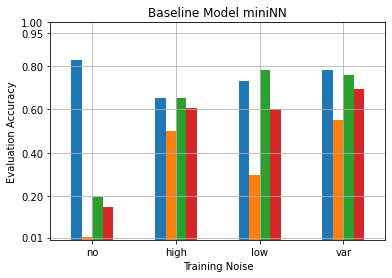

In [96]:
## Plot results for baseline model ####
f = plt.figure(figsize=(6,6))
r_df = results_df.loc[lambda df: df["model"]=="miniNN"].sort_values('model')
plot = r_df.plot(  x="trained_on", 
            y=["no","high","low","var"], 
            kind='bar', 
            title="Baseline Model miniNN",
            xlabel="Training Noise", 
            ylabel="Evaluation Accuracy",
            yticks=[0.01]+[t/10 for t in range(2,11,2)]+[0.95],
            sharey=True,
            legend=False, #i==0,
            grid=True,
            )
lo, la = plt.xticks(rotation=0)

In [ ]:
crit=results_df["trained_on"]=="no"
print(results_df.loc[crit])

for c in ["high","low","var"]:
    crit=results_df["trained_on"]==c
    print(results_df.loc[crit])